# Analysis code for the Wannier-Stark LIOM project

This is some of the code used to process the data generated from the Tensor Flow Equation (TFE) method.



First we import the necessary modules:

In [191]:
import h5py
import core.init as init
import numpy as np
import matplotlib.pyplot as plt

# Part to change plotting system
# Slows things down a little but makes nicer plots
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (6,4)
plt.rc('font',family='serif')
plt.rcParams.update({'font.size': 12})
plt.rc('text', usetex=True)
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'

Now we input the various parameters to import the file we're interested in. This notebook contains plots of the entire flow, and so we restrict ourselves to system sizes of $ n \leq 12$, as otherwise storing $\mathcal{O}(n^4)$ variables for all $\mathcal{O}(10^3)$ flow time steps becomes prohibitive.

In [327]:
# Parameters
n = 8                           # System size
delta = 0.1                     # Nearest-neighbour interaction strength
J = 1.0                         # Nearest-neighbour hopping amplitude

d = 0.50                        # Slope gradient ('disorder strength')
norm = False                    # Normal-ordering, can be true or false
Hflow = True                    # Whether to store the flowing Hamiltonian (true) or generator (false)
                                # Storing H(l) allows SciPy ODE integration to add extra flow time steps
                                # Storing eta(l) reduces number of tensor contractions, at cost of accuracy
                                # NB: if the flow step dl is too large, this can lead to Vint diverging!
precision = np.float32          # Precision with which to store running Hamiltonian/generator
                                # Default throughout is single precision (np.float32)
                                # Using np.float16 will half the memory cost, at loss of precision
                                # Only affects the backwards transform, not the forward transform

intr = True                     # Turn on/off interactions
dyn = False                     # Run the dynamics
imbalance = False               # Sets whether to compute global imbalance or single-site dynamics
LIOM = 'bck'                    # Compute LIOMs with forward ('fwd') or backward ('bck') flow
                                # Forward uses less memory by a factor of qmax, and transforms a local operator
                                # in the initial basis into the diagonal basis; backward does the reverse
dyn_MF = True                   # Mean-field decoupling for dynamics (used only if dyn=True)
logflow = True                  # Use logarithmically spaced steps in flow time
store_flow = True               # Store the full flow of the Hamiltonian and LIOMs
dis_type = 'linear'             # Options: 'random', 'QPgolden', 'QPsilver', 'QPbronze', 'QPrandom', 'linear', 'curved', 'prime'
                                # Also contains 'test' and 'QPtest', potentials that do not change from run to run
x = 0.1                         # For 'dis_type = curved', controls the gradient of the curvature
if intr == False:               # Zero the interactions if set to False (for ED comparison and filename)
    delta = 0
if dis_type != 'curved':
    x = 0.0
    
# Get directory name
nvar = init.namevar(dis_type,dyn,norm,n,LIOM)

with h5py.File('data/%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
    flow = np.array(hf.get('flow'))
    dl_list = np.array(hf.get('dl_list'))
    
print(flow.shape)
print(dl_list.shape)

(1250, 8320)
(1250,)


## Plots

Before taking a look at specific terms, first we plot the flow of all variables in the Hamiltonian, and all variables in the running LIOM. This gives us a crude idea of how well-behaved the overall flow is, and whether there are any divergent or badly-behaved terms.

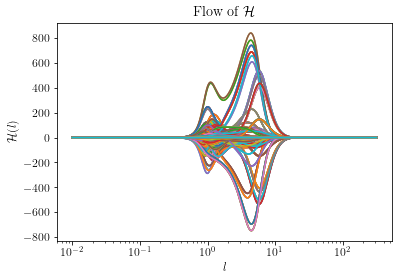

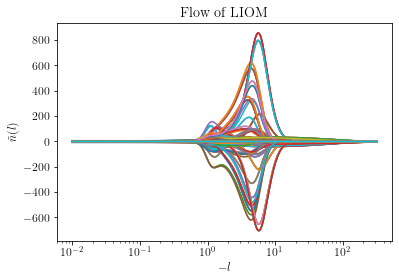

In [328]:
for i in range(n**2+n**4):
    plt.plot(dl_list,flow[::,i])
plt.xscale('log')
plt.title(r'Flow of $\mathcal{H}$')
plt.ylabel(r'$\mathcal{H}(l)$')
plt.xlabel(r'$l$')
plt.show()
plt.close()

for i in range(n**2+n**4,2*(n**2+n**4)):
    if LIOM == 'fwd':
        plt.plot(dl_list,flow[::,i])
    elif LIOM == 'bck':
        plt.plot(dl_list,flow[::,i]) 
plt.xscale('log')
plt.title(r'Flow of LIOM')
plt.ylabel(r'$\tilde{n}(l)$')
plt.xlabel(r'$-l$')
plt.show()
plt.close()

For weak values of 'disorder' (or gradient of linear field), the flow can exhibit temporary increases to extremely large values which mostly vanish again at the end of the flow, but this is nonetheless surprising and strange. At stronger values of disorder/gradient, this does not happen and is not a problem. (Note that this method is not expected to work well in the delocalised phase, and that such pseduo-divergences are probably a sign of a breakdown of the method, rather than anything physical.)

Now we can look at the flow of specific groups of variables. Below I plot the following:

* The flow of the **quadratic** terms in the Hamiltonian.
* The flow of the **quartic** terms in the Hamiltonian.
* The flow of the **quartic** terms in the Hamiltonian on a **double-log** scale.
* The flow of the **quadratic** terms in the LIOM.
* The flow of the **quartic** terms in the LIOM.

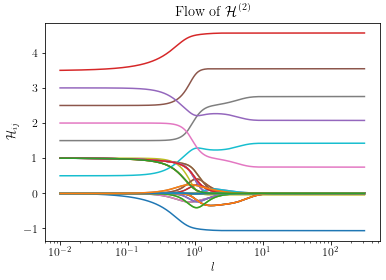

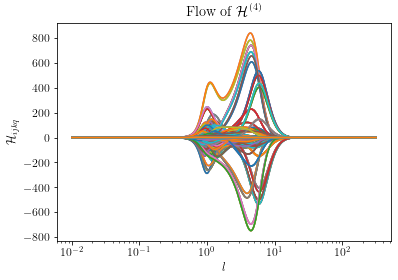

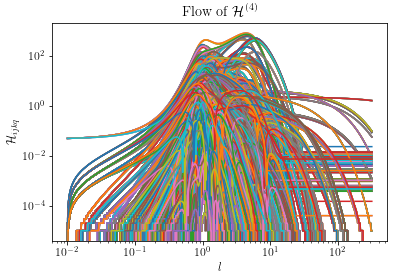

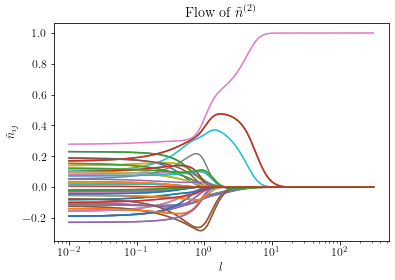

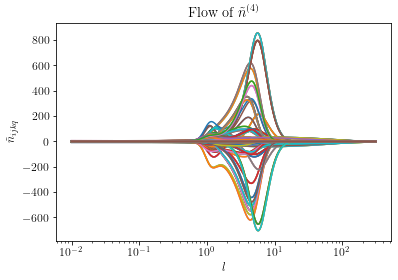

In [329]:
for i in range(n**2):
    plt.plot(dl_list,(flow[::,i]))
plt.xscale('log')
plt.title(r'Flow of $\mathcal{H}^{(2)}$')
plt.ylabel(r'$\mathcal{H}_{ij}$')
plt.xlabel(r'$l$')
plt.show()
plt.close()

for i in range(n**2,n**4):
    plt.plot(dl_list,(flow[::,i]))
plt.xscale('log')
plt.title(r'Flow of $\mathcal{H}^{(4)}$')
plt.ylabel(r'$\mathcal{H}_{ijkq}$')
plt.xlabel(r'$l$')
#plt.ylim(0,5)
plt.show()
plt.close()

for i in range(n**2,n**4):
    plt.plot(dl_list,np.round(np.abs(flow[::,i]),5))
plt.xscale('log')
plt.yscale('log')
plt.title(r'Flow of $\mathcal{H}^{(4)}$')
plt.ylabel(r'$\mathcal{H}_{ijkq}$')
plt.xlabel(r'$l$')
#plt.ylim(0,5)
plt.show()
plt.close()

for i in range(n**2+n**4,2*n**2+n**4):
    plt.plot(dl_list,(flow[::,i]))
plt.xscale('log')
plt.title(r'Flow of $\tilde{n}^{(2)}$')
plt.ylabel(r'$\tilde{n}_{ij}$')
plt.xlabel(r'$l$')
plt.show()
plt.close()

for i in range(2*n**2+n**4,2*(n**2+n**4)):
    plt.plot(dl_list,(flow[::,i]))
plt.xscale('log')
plt.title(r'Flow of $\tilde{n}^{(4)}$')
plt.ylabel(r'$\tilde{n}_{ijkq}$')
plt.xlabel(r'$l$')
plt.show()
plt.close()

We can isolate the diagonal terms of $\mathcal{H}^{(4)}$, i.e. the coefficients of the terms $\sim \Delta_{ij} n_i n_j$ to see how they behave:

In [ ]:
intlist = np.zeros(len(flow))
for k in range(len(flow)):
    Hint2 = (flow[k,n**2:n**2+n**4]).reshape(n,n,n,n)
    HFint = np.zeros(n**2).reshape(n,n)
    off_diag = []
    for i in range(n):
        for j in range(n):
            HFint[i,j] = Hint2[i,i,j,j]
            HFint[i,j] += -Hint2[i,j,j,i]
    intlist[k] = HFint

for i in range(len(flow)):
    plt.plot(intlist[::,i])
plt.show()
plt.close()

In [331]:
list = np.zeros((len(flow),n**2))
l4 = np.sort(flow[-1,2*n**2+n**4:2*n**2+2*n**4])
print(np.sum([i**2 for i in l4]))
for k in range(len(flow)):
    Hint2 = (flow[k,n**2:n**2+n**4]).reshape(n,n,n,n)
    HFint = np.zeros(n**2).reshape(n,n)
    for i in range(n):
        for j in range(n):
            HFint[i,j] = Hint2[i,i,j,j]
            HFint[i,j] += -Hint2[i,j,j,i]
    list[k] = HFint.reshape(n**2)

10491.8176261224
ERROR! Session/line number was not unique in database. History logging moved to new session 18


ERROR! Session/line number was not unique in database. History logging moved to new session 17


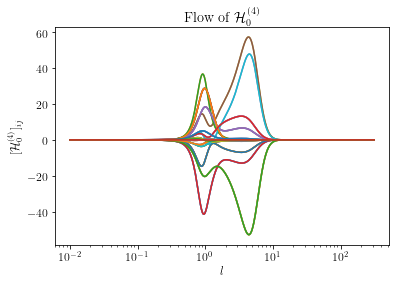

In [330]:
plt.plot(dl_list,list)
plt.xscale('log')
plt.title(r'Flow of $\mathcal{H}_0^{(4)}$')
plt.ylabel(r'$[\mathcal{H}_0^{(4)}]_{ij}$')
plt.xlabel(r'$l$')
plt.show()
plt.close()

## Convergence Measures

We can also check how well the Hamiltonian and LIOM are converged during the flow. We start with the quadratic part off the Hamiltonian:

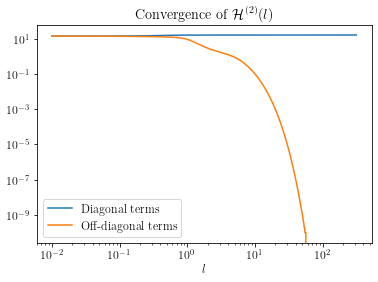

In [332]:
dlist = np.zeros(len(flow))
odlist = np.zeros(len(flow))
for k in range(len(flow)):
    H2 = (flow[k,0:n**2]).reshape(n,n)
    HFint = np.zeros(n**2).reshape(n,n)
    off_diag = []
    H0 = np.diag(np.diag(H2))
    V = H2 - H0
    dlist[k] = np.sum(np.abs(H0).reshape(n**2))
    odlist[k] = np.sum(np.abs(V.reshape(n**2)))
plt.plot(dl_list,np.round(dlist,10),label='Diagonal terms')
plt.plot(dl_list,np.round(odlist,10),label='Off-diagonal terms')
plt.legend()
plt.title(r'Convergence of $\mathcal{H}^{(2)}(l)$')
plt.xlabel(r'$l$')
plt.yscale('log')
plt.xscale('log')
plt.show()
plt.close()

We see here that the off-diagonal quadratic terms vanish at large flow times, as expected. The speed of this decay will depend on the precise dataset chosen, and should be faster for datasets where the diagonal elements are larger.

We can now take a look at the convergence of the **quartic** part of the Hamiltonian by breaking it into diagonal and off-diagonal terms in exactly the same way:

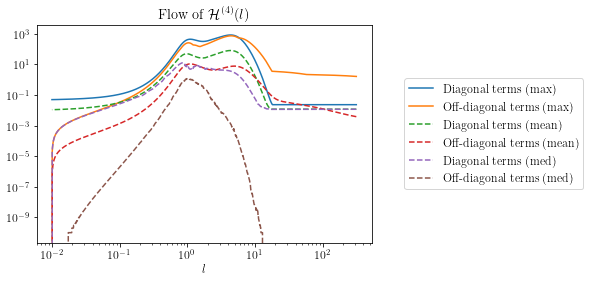

In [333]:
dlist_max = np.zeros(len(flow))
odlist_max = np.zeros(len(flow))
dlist_mean = np.zeros(len(flow))
odlist_mean = np.zeros(len(flow))
dlist_med = np.zeros(len(flow))
odlist_med = np.zeros(len(flow))
for k in range(len(flow)):
    Hint2 = (flow[k,n**2:n**2+n**4]).reshape(n,n,n,n)
    HFint = np.zeros(n**2).reshape(n,n)
    off_diag = []
    for i in range(n):
        for j in range(n):
            for q in range(n):
                for p in range(n):
                    if i==j and p==q:
                        HFint[i,q] = Hint2[i,i,q,q]
                    elif i == p and j==q:
                        HFint[i,j] += -Hint2[i,j,j,i]
                    else:
                        off_diag += [Hint2[i,j,q,p]]

    dlist_max[k] = np.max(np.abs(HFint).reshape(n**2))
    odlist_max[k] = np.max(np.abs(off_diag))
    dlist_mean[k] = np.mean(np.abs(HFint).reshape(n**2))
    odlist_mean[k] = np.mean(np.abs(off_diag))
    dlist_med[k] = np.median(np.abs(HFint).reshape(n**2))
    odlist_med[k] = np.median(np.abs(off_diag))
    
plt.plot(dl_list,np.round(dlist_max,10),label='Diagonal terms (max)')
plt.plot(dl_list,np.round(odlist_max,10),label='Off-diagonal terms (max)')
plt.plot(dl_list,np.round(dlist_mean,10),'--',label='Diagonal terms (mean)')
plt.plot(dl_list,np.round(odlist_mean,10),'--',label='Off-diagonal terms (mean)')
plt.plot(dl_list,np.round(dlist_med,10),'--',label='Diagonal terms (med)')
plt.plot(dl_list,np.round(odlist_med,10),'--',label='Off-diagonal terms (med)')
plt.legend(loc='center right',bbox_to_anchor=(1.65,0.5))
plt.title(r'Flow of $\mathcal{H}^{(4)}(l)$')
plt.xlabel(r'$l$')
plt.yscale('log')
plt.xscale('log')
plt.show()
plt.close()

The flow of the interacting part of the Hamiltonian is non-monotonic, and in particular the off-diagonal part (which is zero at the start of the flow) can become extremely large for some choices of the slope gradient, however it always shrinks again at late values of the flow. This can be a big problem for computing/storing the backwards transform, as this pseudo-divergence has to be stored at very high accuracy to avoid the reverse transform also diverging due to small errors accumulated throughout the process.

We can now examine the flow of the LIOMs. Remember that there is no reason that the LIOMs should be diagonal, and in fact in general they will not be. We start from the **quadratic** part of the LIOM:

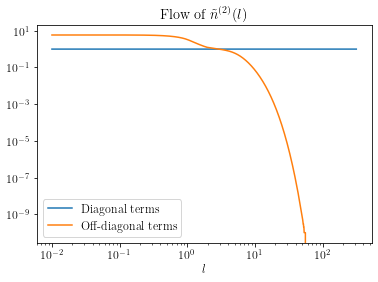

In [334]:
dlist = np.zeros(len(flow))
odlist = np.zeros(len(flow))
for k in range(len(flow)):
    H2 = (flow[k,n**2+n**4:2*n**2+n**4]).reshape(n,n)
    HFint = np.zeros(n**2).reshape(n,n)
    off_diag = []
    H0 = np.diag(np.diag(H2))
    V = H2 - H0
    dlist[k] = np.sum(np.abs(H0).reshape(n**2))
    odlist[k] = np.sum(np.abs(V.reshape(n**2)))
plt.plot(dl_list,np.round(dlist,10),label='Diagonal terms')
plt.plot(dl_list,np.round(odlist,10),label='Off-diagonal terms')
plt.legend()
plt.title(r'Flow of $\tilde{n}^{(2)}(l)$')
plt.xlabel(r'$l$')
plt.yscale('log')
plt.xscale('log')
plt.show()
plt.close()

And again, we can do the same for the **quartic** terms in the LIOM to see how they behave. They are also typically non-monotonic.

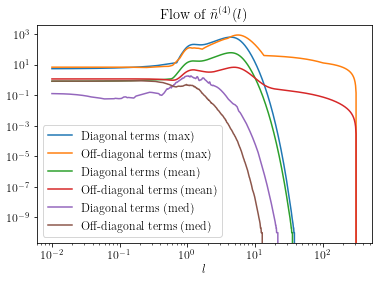

In [335]:
dlist_max = np.zeros(len(flow))
odlist_max = np.zeros(len(flow))
dlist_mean = np.zeros(len(flow))
odlist_mean = np.zeros(len(flow))
dlist_med = np.zeros(len(flow))
odlist_med = np.zeros(len(flow))
for k in range(len(flow)):
    Hint2 = (flow[k,2*n**2+n**4:2*n**2+2*n**4]).reshape(n,n,n,n)
    HFint = np.zeros(n**2).reshape(n,n)
    off_diag = []
    for i in range(n):
        for j in range(n):
            for q in range(n):
                for p in range(n):
                    if i==j and p==q:
                        HFint[i,q] = Hint2[i,i,q,q]
                    elif i == p and j==q:
                        HFint[i,j] += -Hint2[i,j,j,i]
                    else:
                        off_diag += [Hint2[i,j,q,p]]

    dlist_max[k] = np.max(np.abs(HFint).reshape(n**2))
    odlist_max[k] = np.max(np.abs(off_diag))
    dlist_mean[k] = np.mean(np.abs(HFint).reshape(n**2))
    odlist_mean[k] = np.mean(np.abs(off_diag))
    dlist_med[k] = np.median(np.abs(HFint).reshape(n**2))
    odlist_med[k] = np.median(np.abs(off_diag))
    
plt.plot(dl_list,np.round(dlist_max,10),label='Diagonal terms (max)')
plt.plot(dl_list,np.round(odlist_max,10),label='Off-diagonal terms (max)')
plt.plot(dl_list,np.round(dlist_mean,10),label='Diagonal terms (mean)')
plt.plot(dl_list,np.round(odlist_mean,10),label='Off-diagonal terms (mean)')
plt.plot(dl_list,np.round(dlist_med,10),label='Diagonal terms (med)')
plt.plot(dl_list,np.round(odlist_med,10),label='Off-diagonal terms (med)')
plt.legend()
plt.title(r'Flow of $\tilde{n}^{(4)}(l)$')
plt.xlabel(r'$l$')
plt.yscale('log')
plt.xscale('log')
plt.show()
plt.close()

# Possible Divergences?

This isn't a true divergence, but for some values of the slope gradient the flow reaches some very large intermediate values before eventually converging. I'm not sure why this is happening, or why the slope gradient $\sim 0.75$ is so particularly bad. Perhaps this is the phase transition, but in that case I'm not sure why the error is largest right at the transition, rather than everywhere in the delocalized phase.

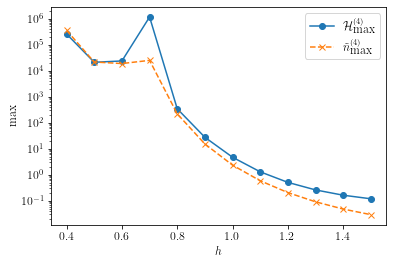

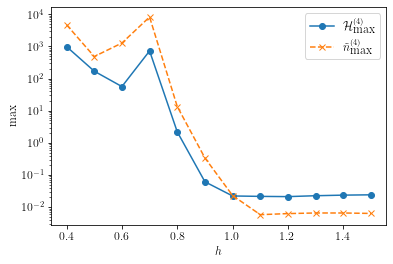

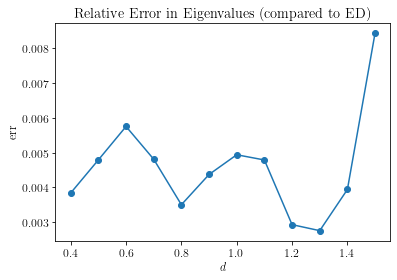

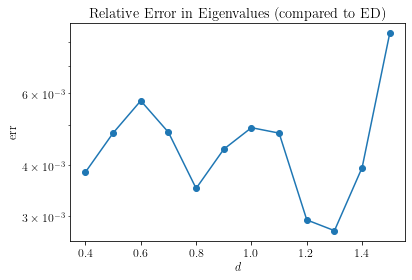

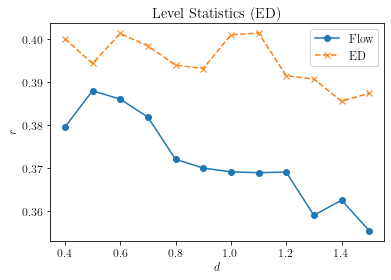

In [337]:
dis = [0.4+0.1*i for i in range(12)]
n = 12
# Get directory name
nvar = init.namevar(dis_type,dyn,norm,n,LIOM)

hlist = np.zeros(len(dis))
nlist = np.zeros(len(dis))
hlist2 = np.zeros(len(dis))
nlist2 = np.zeros(len(dis))
errlist = np.zeros(len(dis))
rlist = np.zeros((len(dis),2))

count = 0
for d in dis:
    with h5py.File('data/%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
        flow = np.array(hf.get('flow'))
        err = np.array(hf.get('err'))
        r = np.array(hf.get('lsr'))
        
    H4flow = flow[::,n**2:n**2+n**4]
    n4flow = flow[::,2*n**2+n**4::]
    
    hlist[count] = np.max(np.abs(H4flow))
    nlist[count] = np.max(np.abs(n4flow))
    hlist2[count] = np.max(np.abs(H4flow)[0])
    nlist2[count] = np.max(np.abs(n4flow)[-1])
    errlist[count] = np.mean(err)
    rlist[count] = r
    
    count += 1
    
plt.plot(dis,hlist,'-o',label=r'$\mathcal{H}^{(4)}_{\textrm{max}}$')
plt.plot(dis,nlist,'--x',label=r'$\tilde{n}^{(4)}_{\textrm{max}}$')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$h$')
plt.ylabel(r'$\textrm{max}$')
plt.show()
plt.close()

plt.plot(dis,hlist2,'-o',label=r'$\mathcal{H}^{(4)}_{\textrm{max}}$')
plt.plot(dis,nlist2,'--x',label=r'$\tilde{n}^{(4)}_{\textrm{max}}$')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$h$')
plt.ylabel(r'$\textrm{max}$')
plt.show()
plt.close()

plt.plot(dis,errlist,'-o')
plt.title(r'Relative Error in Eigenvalues (compared to ED)')
plt.xlabel(r'$d$')
plt.ylabel(r'$\textrm{err}$')
plt.show()
plt.close()

plt.plot(dis,errlist,'-o')
plt.yscale('log')
plt.title(r'Relative Error in Eigenvalues (compared to ED)')
plt.xlabel(r'$d$')
plt.ylabel(r'$\textrm{err}$')
plt.show()
plt.close()

plt.plot(dis,rlist[::,0],'-o',label='Flow')
plt.plot(dis,rlist[::,1],'--x',label='ED')
plt.legend()
plt.title(r'Level Statistics (ED)')
plt.xlabel(r'$d$')
plt.ylabel(r'$r$')
plt.show()
plt.close()

# LIOMS

We can now take a look at the LIOM interaction terms in the fixed-point Hamiltonian $\Delta_{ij}$, and the real-space support of the LIOMS themselves.

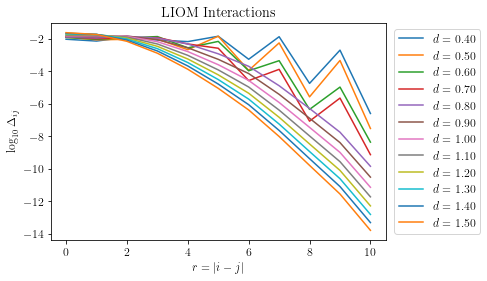

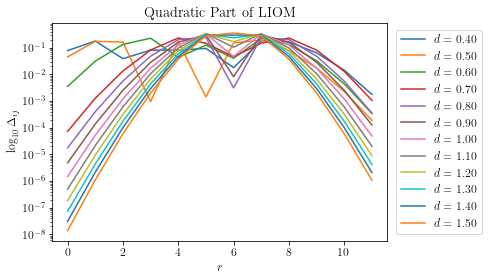

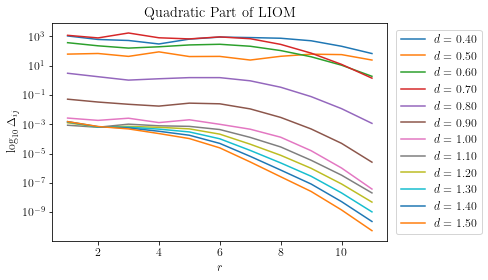

In [338]:
dis = [0.4+0.1*i for i in range(12)]
n = 12
# Get directory name
nvar = init.namevar(dis_type,dyn,norm,n,LIOM)


# Plot decay of the LIOM interactions 
for d in dis:
    with h5py.File('data/%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
        lbits = np.array(hf.get('lbits'))
    plt.plot(lbits,label=r'$d = %.2f$' %d)
plt.legend(loc='center right',bbox_to_anchor=(1.3,0.5))
plt.title(r'LIOM Interactions')
plt.xlabel(r'$r=|i-j|$')
plt.ylabel(r'$\log_{10} \Delta_{ij}$')
plt.show()
plt.close()

# Plot support of the quadratic (non-interacting) part of the LIOM
for d in dis:
    with h5py.File('data/%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
        liom = np.array(hf.get('liom'))
    plt.plot(np.abs(np.diag(liom[:n**2].reshape(n,n))),label=r'$d = %.2f$' %d)
plt.legend(loc='center right',bbox_to_anchor=(1.3,0.5))
plt.yscale('log')
plt.title('Quadratic Part of LIOM')
plt.xlabel(r'$r$')
plt.ylabel(r'$\log_{10} \Delta_{ij}$')
plt.show()
plt.close()

# Plot support of the quartic (interacting) part of the LIOM
for d in dis:
    with h5py.File('data/%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
        liom = np.array(hf.get('liom'))
        l4 = liom[n**2:n**2+n**4].reshape(n,n,n,n)
        
        mat = np.ones((n,n))    
        for i in range(n):              
            for j in range(n):
                if i != j:
                    # Load dHint_diag with diagonal values (n_i n_j or c^dag_i c_j c^dag_j c_i)
                    mat[i,j] = l4[i,i,j,j]
                    mat[i,j] = -l4[i,j,j,i]
        l4_list = np.zeros(n-1)
        for k in range(1,n):
            l4_list[k-1] = np.mean(np.abs(np.diag(mat,k)))
            
    plt.plot(range(1,n),l4_list,label=r'$d = %.2f$' %d)
    
plt.legend(loc='center right',bbox_to_anchor=(1.3,0.5))
plt.yscale('log')
plt.title('Quadratic Part of LIOM')
plt.xlabel(r'$r$')
plt.ylabel(r'$\log_{10} \Delta_{ij}$')
plt.show()
plt.close()
